8 blocks
Matrix Size  Block Size   Dense (ms)   BMM (ms)     Speedup      BMM GFLOPS  
32x32      4x4           0.02         0.01       1.60x         0.1
64x64      8x8           0.01         0.01       1.12x         0.7
128x128     16x16          0.01         0.01       1.17x         5.5
256x256     32x32          0.02         0.01       1.36x        37.1
512x512     64x64          0.04         0.02       2.14x       255.0
1024x1024    128x128         0.14         0.02       6.84x      1585.6
2048x2048    256x256         0.95         0.03      28.89x      8182.4
4096x4096    512x512         5.05         0.11      46.21x     19653.5
8192x8192    1024x1024       32.81         0.72      45.26x     23698.8
16384x16384   2048x2048      312.60         6.50      48.10x     21148.5


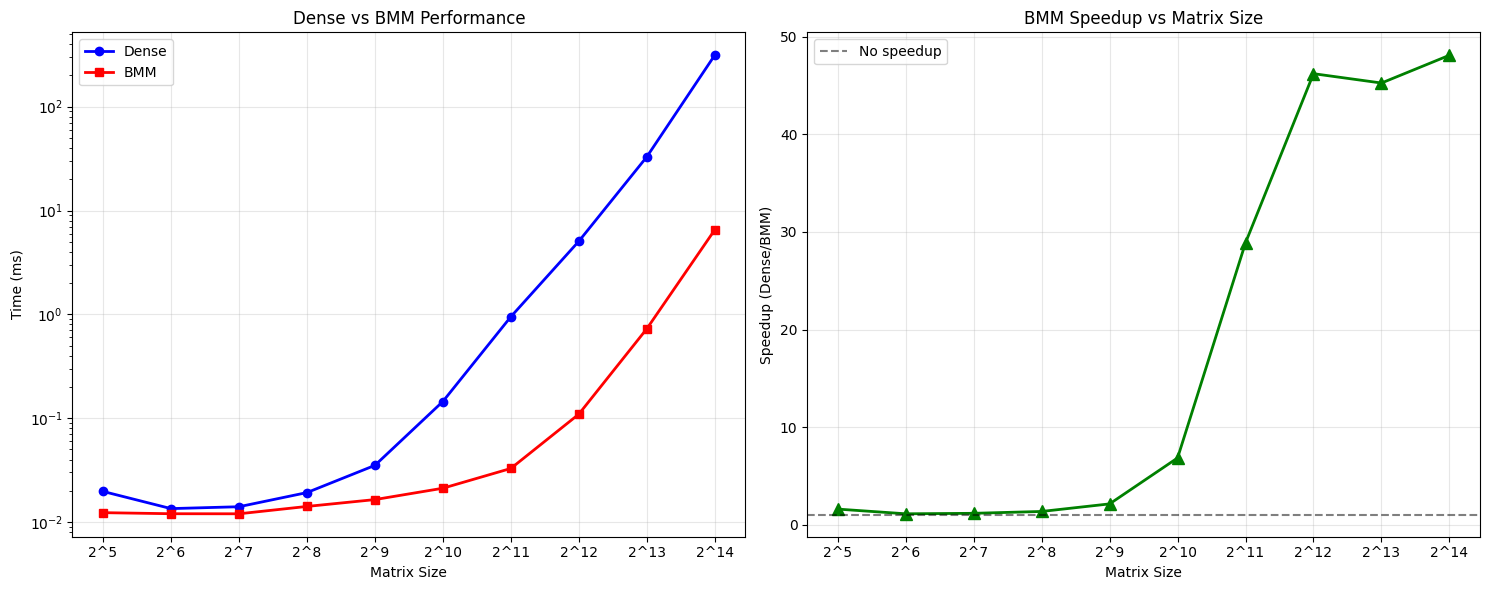

In [9]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import random

# Configuration
matrix_sizes = [2**i for i in range(5, 15)]
powers = list(range(5, 15))
num_blocks = 8
num_trials = 50

print(f"{num_blocks} blocks")
print(f"{'Matrix Size':<12} {'Block Size':<12} {'Dense (ms)':<12} {'BMM (ms)':<12} {'Speedup':<12} {'BMM GFLOPS':<12}")

# Store results for plotting
dense_times = []
bmm_times = []
speedups = []

for N in matrix_sizes:
    block_size = N // num_blocks

    # Generate random block diagonal matrices
    A_blocks = [torch.randn(block_size, block_size, device="cuda", dtype=torch.float16)
                for _ in range(num_blocks)]
    B_blocks = [torch.randn(block_size, block_size, device="cuda", dtype=torch.float16)
                for _ in range(num_blocks)]

    # Dense approach
    dense_A = torch.block_diag(*A_blocks)
    dense_B = torch.block_diag(*B_blocks)

    # BMM approach
    A_batched = torch.stack(A_blocks)
    B_batched = torch.stack(B_blocks)

    # Warm up
    for _ in range(5):
        _ = dense_A @ dense_B
        _ = torch.bmm(A_batched, B_batched)
    torch.cuda.synchronize()

    # Dense
    start = time.time()
    for _ in range(num_trials):
        _ = dense_A @ dense_B
    torch.cuda.synchronize()
    dense_time = (time.time() - start) / num_trials

    # BMM
    start = time.time()
    for _ in range(num_trials):
        _ = torch.bmm(A_batched, B_batched)
    torch.cuda.synchronize()
    bmm_time = (time.time() - start) / num_trials

    # Store for plotting
    dense_times.append(dense_time * 1000)
    bmm_times.append(bmm_time * 1000)
    speedup = dense_time / bmm_time
    speedups.append(speedup)

    # Calculate metrics
    total_flops = 2 * num_blocks * block_size**3
    bmm_gflops = total_flops / bmm_time / 1e9

    print(f"{N}x{N:<7} {block_size}x{block_size:<7} {dense_time*1000:>8.2f}     {bmm_time*1000:>8.2f}     {speedup:>6.2f}x    {bmm_gflops:>8.1f}")

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Performance comparison
ax1.semilogy(powers, dense_times, 'b-o', label='Dense', linewidth=2, markersize=6)
ax1.semilogy(powers, bmm_times, 'r-s', label='BMM', linewidth=2, markersize=6)
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Dense vs BMM Performance')
ax1.set_xticks(powers)
ax1.set_xticklabels([f'2^{p}' for p in powers])
ax1.grid(True, alpha=0.3)
ax1.legend()

# Speedup plot
ax2.plot(powers, speedups, 'g-^', linewidth=2, markersize=8)
ax2.set_xlabel('Matrix Size')
ax2.set_ylabel('Speedup (Dense/BMM)')
ax2.set_title('BMM Speedup vs Matrix Size')
ax2.set_xticks(powers)
ax2.set_xticklabels([f'2^{p}' for p in powers])
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No speedup')
ax2.legend()

plt.tight_layout()
plt.show()